In [1]:
!pip install matplotlib
!pip install scipy
#This abandoned version is after only freezing the first 14/15 layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


import keras
from keras import Model
import keras.layers as layers
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import image_dataset_from_directory, Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras import datasets
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-03-21 18:51:32.598682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 18:51:32.734401: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 18:51:33.425514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 18:51:33.425608: W tensorflow/

In [2]:
img_train_path = os.path.join("DATASET","TRAIN")
img_test_path = os.path.join("DATASET","TEST")
img_SET1_path = os.path.join("DATASET","CROSS/SET1")
img_SET2_path = os.path.join("DATASET","CROSS/SET2")
img_SET3_path = os.path.join("DATASET","CROSS/SET3")
img_SET1_SET2_path = os.path.join("DATASET","CROSS/SET1_SET2")
img_SET1_SET3_path = os.path.join("DATASET","CROSS/SET1_SET3")
img_SET2_SET3_path = os.path.join("DATASET","CROSS/SET2_SET3")

data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
BATCH_SIZE = 128

raw_generator = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET1_generator = data_gen.flow_from_directory(img_SET1_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET2_generator = data_gen.flow_from_directory(img_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET3_generator = data_gen.flow_from_directory(img_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET1_generator = data_gen.flow_from_directory(img_SET1_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET2_generator = data_gen.flow_from_directory(img_SET1_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET3_generator = data_gen.flow_from_directory(img_SET2_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
test_generator = data_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=BATCH_SIZE)

Found 22564 images belonging to 2 classes.
Found 7447 images belonging to 2 classes.
Found 7672 images belonging to 2 classes.
Found 7445 images belonging to 2 classes.
Found 15119 images belonging to 2 classes.
Found 14892 images belonging to 2 classes.
Found 15117 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
img, _= next(raw_generator)
print(img.shape)

(128, 256, 256, 3)


In [4]:
def rebuild_model():
    global pretrained_model
    global model
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

    #freezing layers
    len_trainable_layers = int((14/15*len(pretrained_model.layers)))
    for layer in pretrained_model.layers[0:len_trainable_layers]:
        layer.trainable = False
    model = keras.Sequential()

    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)
rebuild_model()
pretrained_model.summary()

2023-03-21 18:51:36.720503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:51:36.754518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:51:36.754719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:51:36.756926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:51:36.757091: I tensorflow/compiler/xla/stream_executo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

 conv4_block2_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
          

 conv5_block1_add (Add)         (None, 8, 8, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [5]:
# reduce time and overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,801,282
Trainable params: 5,679,234
Non

Epoch 1/30


2023-03-21 18:51:49.327051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-21 18:51:51.501162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:51:51.648566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

  2/118 [..............................] - ETA: 11s - loss: 0.6952 - accuracy: 0.5391  

2023-03-21 18:51:54.657898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 99/118 [========================>.....] - ETA: 4s - loss: 0.5213 - accuracy: 0.7453

2023-03-21 18:52:21.259556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:52:21.279210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-21 18:52:21.462878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 512 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 512 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:52:21.469952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 2048 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 2048 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an iden

118/118 [==============================] - 63s 435ms/step - loss: 0.5161 - accuracy: 0.7487 - val_loss: 1.1456 - val_accuracy: 0.4553
Epoch 2/30
118/118 [==============================] - 47s 396ms/step - loss: 0.4484 - accuracy: 0.7972 - val_loss: 0.5607 - val_accuracy: 0.6867
Epoch 3/30
118/118 [==============================] - 50s 423ms/step - loss: 0.4197 - accuracy: 0.8135 - val_loss: 1.7723 - val_accuracy: 0.4445
Epoch 4/30
118/118 [==============================] - 46s 393ms/step - loss: 0.4035 - accuracy: 0.8224 - val_loss: 0.7803 - val_accuracy: 0.6235
Epoch 5/30
118/118 [==============================] - 45s 377ms/step - loss: 0.3895 - accuracy: 0.8262 - val_loss: 0.4739 - val_accuracy: 0.7702
Epoch 6/30
118/118 [==============================] - 46s 388ms/step - loss: 0.3837 - accuracy: 0.8304 - val_loss: 0.8699 - val_accuracy: 0.6933
Epoch 7/30
118/118 [==============================] - 47s 400ms/step - loss: 0.3717 - accuracy: 0.8374 - val_loss: 0.5499 - val_accuracy: 0.7

2023-03-21 18:59:53.284533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:59:53.366972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 8s 386ms/step - loss: 0.5038 - accuracy: 0.7684
test loss, test acc: [0.503849446773529, 0.7684043049812317]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


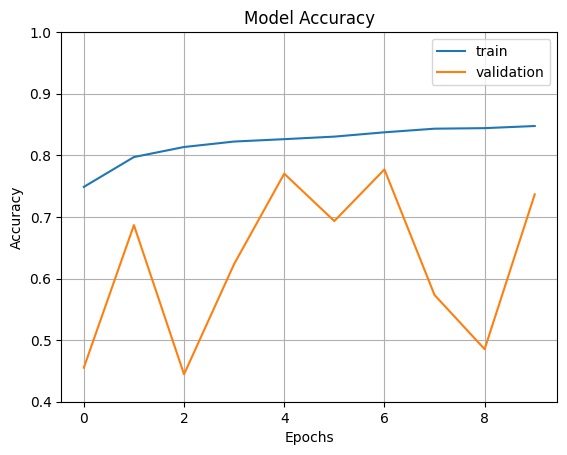

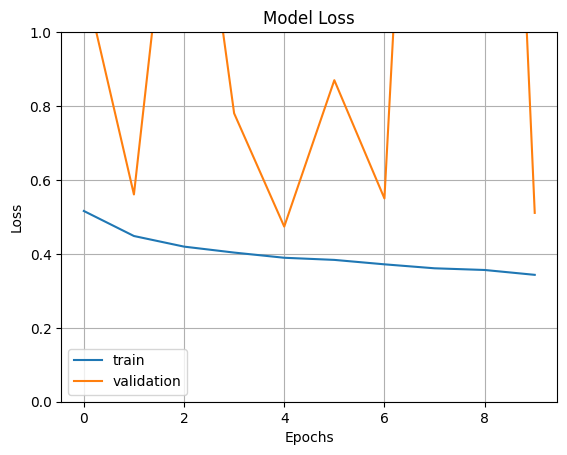

In [6]:
train_generator = CSET1_generator
validation_generator = SET3_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#bad result

Epoch 1/30
 21/116 [====>.........................] - ETA: 23s - loss: 0.7118 - accuracy: 0.6246

2023-03-21 19:00:10.430567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:00:10.474983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-21 19:00:10.852090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 2048 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 2048 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.


116/116 [==============================] - 56s 434ms/step - loss: 0.5446 - accuracy: 0.7331 - val_loss: 2.0068 - val_accuracy: 0.5837
Epoch 2/30
116/116 [==============================] - 46s 394ms/step - loss: 0.4413 - accuracy: 0.8014 - val_loss: 0.5289 - val_accuracy: 0.7233
Epoch 3/30
116/116 [==============================] - 47s 406ms/step - loss: 0.4202 - accuracy: 0.8124 - val_loss: 5.1609 - val_accuracy: 0.5675
Epoch 4/30
116/116 [==============================] - 45s 391ms/step - loss: 0.4047 - accuracy: 0.8204 - val_loss: 1.7847 - val_accuracy: 0.4899
Epoch 5/30
116/116 [==============================] - 46s 399ms/step - loss: 0.4012 - accuracy: 0.8226 - val_loss: 0.6549 - val_accuracy: 0.7296
Epoch 6/30
116/116 [==============================] - 48s 410ms/step - loss: 0.3789 - accuracy: 0.8362 - val_loss: 0.4640 - val_accuracy: 0.8112
Epoch 7/30
116/116 [==============================] - 46s 399ms/step - loss: 0.3731 - accuracy: 0.8366 - val_loss: 1.4902 - val_accuracy: 0.6

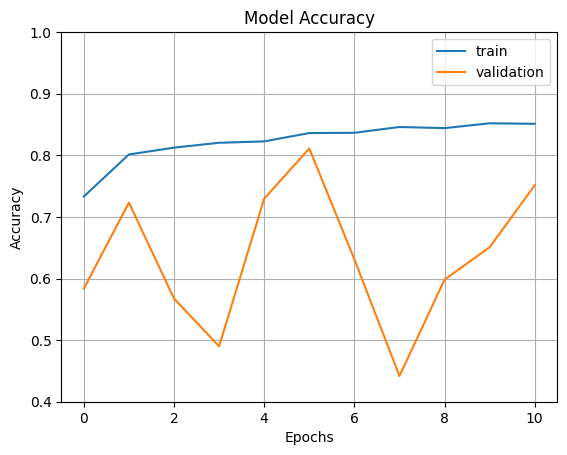

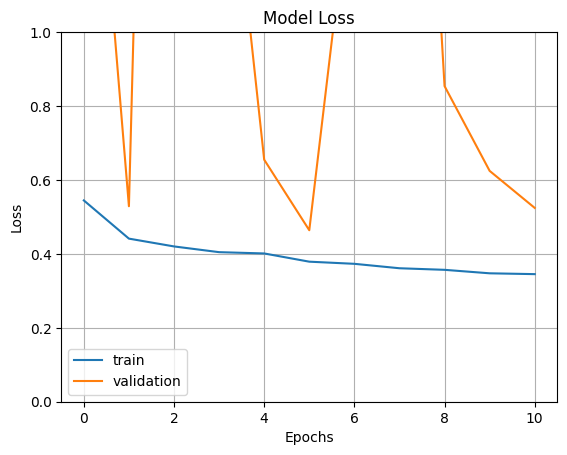

In [7]:
train_generator = CSET2_generator
validation_generator = SET2_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/30
110/118 [==========================>...] - ETA: 2s - loss: 0.5293 - accuracy: 0.7422

2023-03-21 19:09:29.910489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:09:29.927807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 62s 482ms/step - loss: 0.5254 - accuracy: 0.7445 - val_loss: 0.6442 - val_accuracy: 0.6246
Epoch 2/30
118/118 [==============================] - 47s 395ms/step - loss: 0.4461 - accuracy: 0.8013 - val_loss: 2.2130 - val_accuracy: 0.4422
Epoch 3/30
118/118 [==============================] - 46s 388ms/step - loss: 0.4263 - accuracy: 0.8093 - val_loss: 0.8657 - val_accuracy: 0.5222
Epoch 4/30
118/118 [==============================] - 48s 403ms/step - loss: 0.4012 - accuracy: 0.8233 - val_loss: 0.5421 - val_accuracy: 0.7439
Epoch 5/30
118/118 [==============================] - 49s 412ms/step - loss: 0.3922 - accuracy: 0.8267 - val_loss: 4.6425 - val_accuracy: 0.4436
Epoch 6/30
118/118 [==============================] - 46s 393ms/step - loss: 0.3775 - accuracy: 0.8339 - val_loss: 6.3226 - val_accuracy: 0.4432
Epoch 7/30
118/118 [==============================] - 49s 416ms/step - loss: 0.3685 - accuracy: 0.8395 - val_loss: 1.3754 - val_accuracy: 0.4

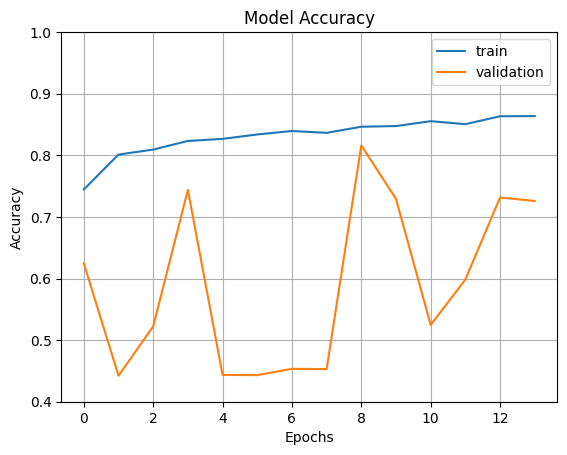

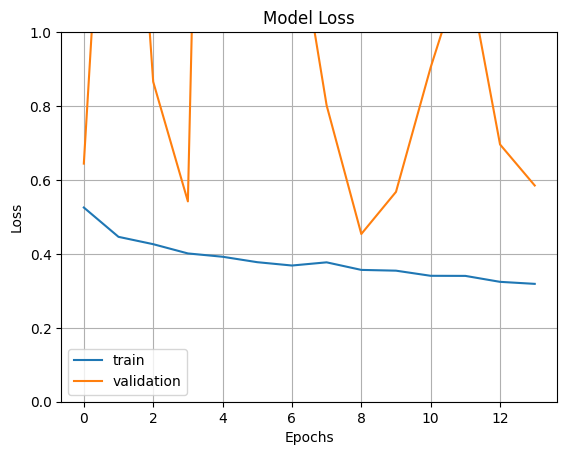

In [8]:
train_generator =  CSET3_generator
validation_generator = SET1_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

2023-03-21 19:20:18.126552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:20:18.162909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

4/4 [==============================] - 3s 30ms/step


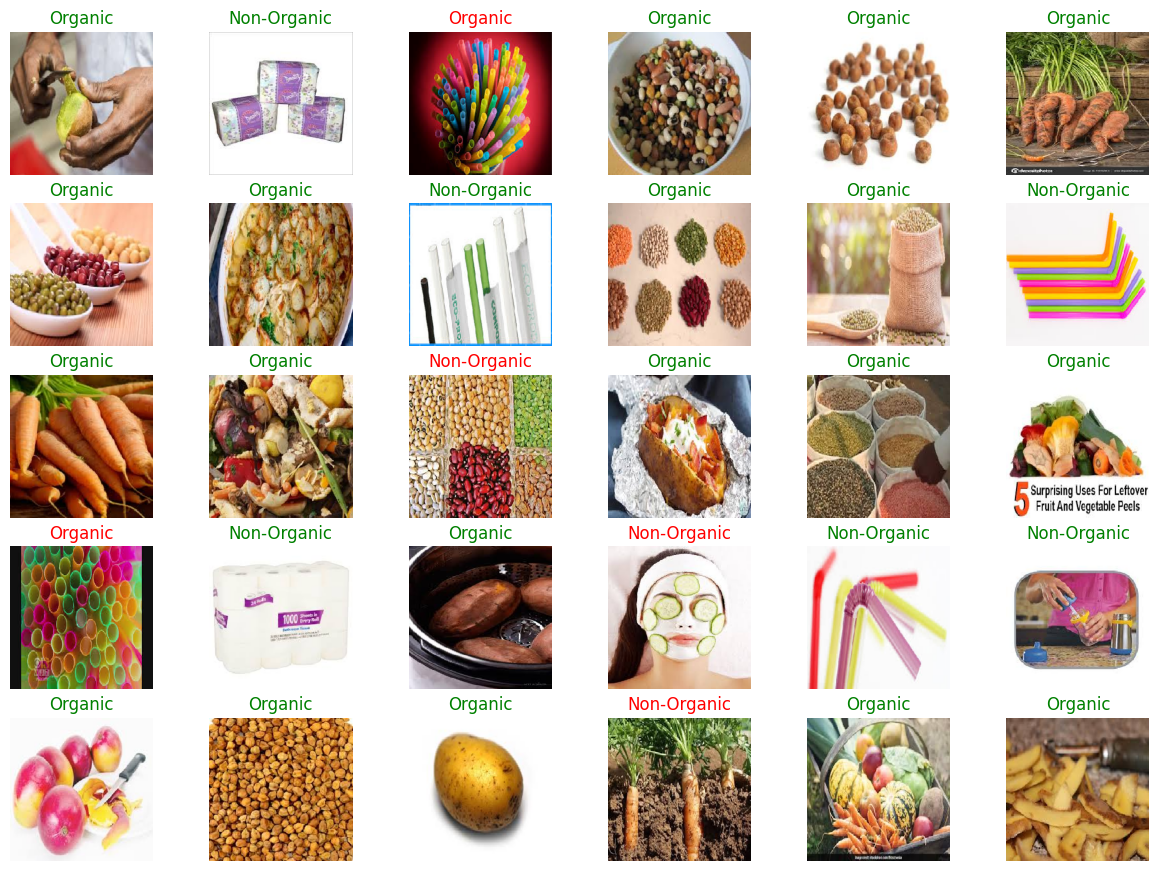

In [9]:
img, _= next(test_generator)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else: 
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else: 
            plt.title("Non-Organic", color='red')
    plt.axis("off")